#dataset resources:
https://www.kaggle.com/datasets/awsaf49/brats2020-training-data

https://www.kaggle.com/code/shreyasdomde/brain-tumor/input



#**Evaluating the Efficacy of Pre-Trained Deep Learning Models in Multi-Class Tumor Detection from Medical Imaging.**

##Introduction:

This project aims to harness and enhance the capabilities of pre-trained deep learning models, including Convolutional Neural Networks (CNNs) such as Resnet50 and VGG16, and Transformers using ViT for medical image classification with a focus on tumor detection.

##Objectives:

To fine-tune these models on a curated medical image dataset to optimize their performance for the specific task of tumor detection.
To evaluate and compare the accuracy and effectiveness of these models in identifying tumors in medical images, with the goal of determining which model is most effective for tumor diagnosis and potentially contributing to improved treatment outcomes.

##Data Gathering:

In this project, the primary dataset is sourced from Kaggle. For further enhancement of our research and to incorporate a broader range of annotated medical images, it is recommended to consider using The Cancer Imaging Archive (TCIA). This publicly accessible repository is a valuable resource for obtaining extensive collections of cancer-related medical images, making it highly beneficial for advanced studies and developments in medical image analysis.

##Model resources:
This project will utilize the PyTorch model zoos as primary sources for pre-trained deep learning models, including CNNs and Transformers. These models, trained on extensive image datasets, provide a solid foundation for fine-tuning to the specific task of tumor classification in medical images.

In [ ]:
!pip install -q torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 841.5/841.5 kB 7.0 MB/s eta 0:00:00


In [ ]:

from IPython.display import clear_output
!pip install imutils
clear_output()

# Import needed libraries
import torch
import torchvision
import torch.nn as nn  # All neural network modules, nn.Linear, nn.Conv2d, BatchNorm, Loss functions
import torch.nn.functional as F  # All functions that don't have any parameters
from torchvision import models, datasets, transforms
from torchsummary import summary
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim # For all Optimization algorithms, SGD, Adam, etc.
from torch.optim import lr_scheduler
from torch.optim import Adam
import torchmetrics
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
import cv2
from PIL import Image

In [ ]:
# upload the `kaggle.json` file and configure the Kaggle API
from google.colab import files
uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

# move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 68 bytes


In [ ]:
# Downloading the dataset
!kaggle datasets download -d sartajbhuvaji/brain-tumor-classification-mri --force


 86% 75.0M/86.8M [00:00<00:00, 104MB/s]
100% 86.8M/86.8M [00:00<00:00, 111MB/s]


In [ ]:
import zipfile
import os

# Extract the ZIP file
with zipfile.ZipFile('/content/brain-tumor-classification-mri.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/brain_tumor_classification_mri')

# Rename the extracted directory
os.rename('/content/brain_tumor_classification_mri', '/content/Tumor_Detection')

## create our training and test sets. We'll make corresponding lists of filepaths and labels.

In [ ]:
# Specify local directories for training and testing data
train_dir = "/content/Tumor_Detection/Training"
test_dir = "/content/Tumor_Detection/Testing"

# Classes (target classses)
class_names = os.listdir(train_dir)
print("Unique classes in the target:", class_names)

Unique classes in the target: ['glioma_tumor', 'pituitary_tumor', 'no_tumor', 'meningioma_tumor']


In [ ]:
# List of labels corresponding to dataset folders
labels = ['glioma_tumor','no_tumor','meningioma_tumor','pituitary_tumor']

X_train = []
y_train = []

# add filepaths and labels to train lists
for label in labels:
    for image in os.listdir(train_dir + '/' + label):
        X_train.append(train_dir + '/' + label + '/' + image)
        y_train.append(label)

print(f"Number of Images in Train set: {len(X_train)}")
print(f"Number of Labels in Train set: {len(y_train)}")
print(X_train[:3], y_train[:3], sep='\n')

Number of Images in Train set: 2870
Number of Labels in Train set: 2870
['/content/Tumor_Detection/Training/glioma_tumor/gg (593).jpg', '/content/Tumor_Detection/Training/glioma_tumor/gg (645).jpg', '/content/Tumor_Detection/Training/glioma_tumor/gg (202).jpg']
['glioma_tumor', 'glioma_tumor', 'glioma_tumor']


In [ ]:
# initialize empty lists
X_test = []
y_test = []

# add filepaths and labels to test lists
for label in labels:
    for image in os.listdir(test_dir + '/' + label):
        X_test.append(test_dir + '/' + label + '/' + image)
        y_test.append(label)

print(f"Number of Images in Test set: {len(X_test)}")
print(f"Number of Labels in Test set: {len(y_test)}")
print(X_test[:3], y_test[:3], sep='\n')

Number of Images in Test set: 394
Number of Labels in Test set: 394
['/content/Tumor_Detection/Testing/glioma_tumor/image(57).jpg', '/content/Tumor_Detection/Testing/glioma_tumor/image(89).jpg', '/content/Tumor_Detection/Testing/glioma_tumor/image(68).jpg']
['glioma_tumor', 'glioma_tumor', 'glioma_tumor']


In [ ]:
import glob
Testing = glob.glob('../content/Tumor_Detection/Testing/*/*.jpg')
Training = glob.glob('../content/Tumor_Detection/Training/*/*.jpg')
Total_Images = Testing + Training
print("Total number of images: ", len(Total_Images))

Total_Images = pd.Series(Total_Images)

Total number of images:  3264


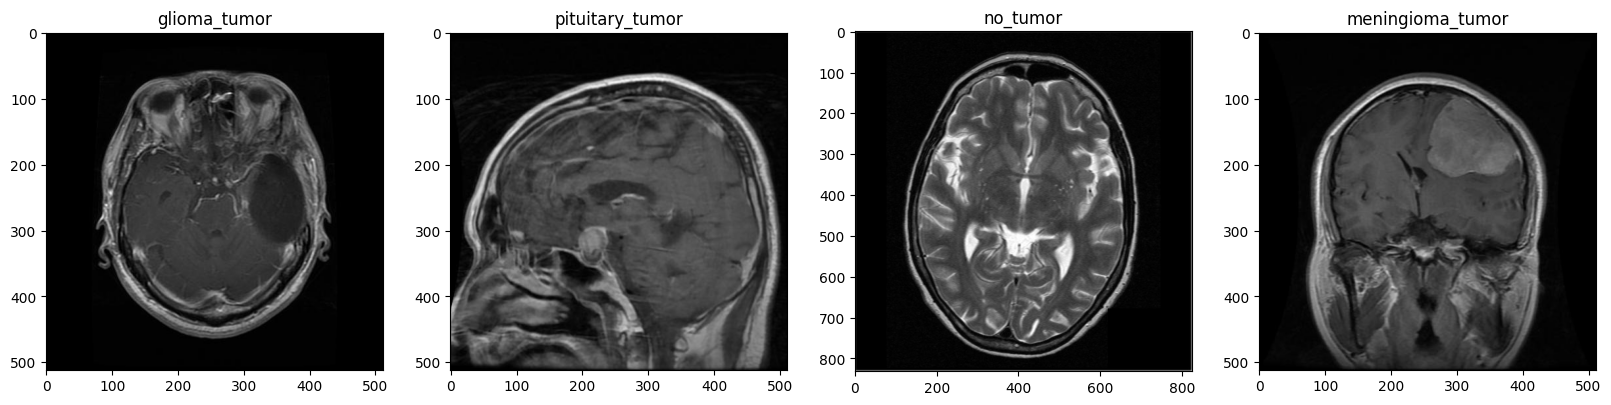

In [ ]:
# Visualizing
k=0
plt.figure(figsize=(20, 20))
for i in os.listdir(train_dir):
    for img_path in os.listdir(os.path.join(train_dir, i))[:1]:
        plt.subplot(1, 4, k + 1)
        img = cv2.imread(os.path.join(train_dir, i, img_path))
        plt.imshow(img)
        plt.title(i)
        k += 1
plt.show()


#**Class Distribution**

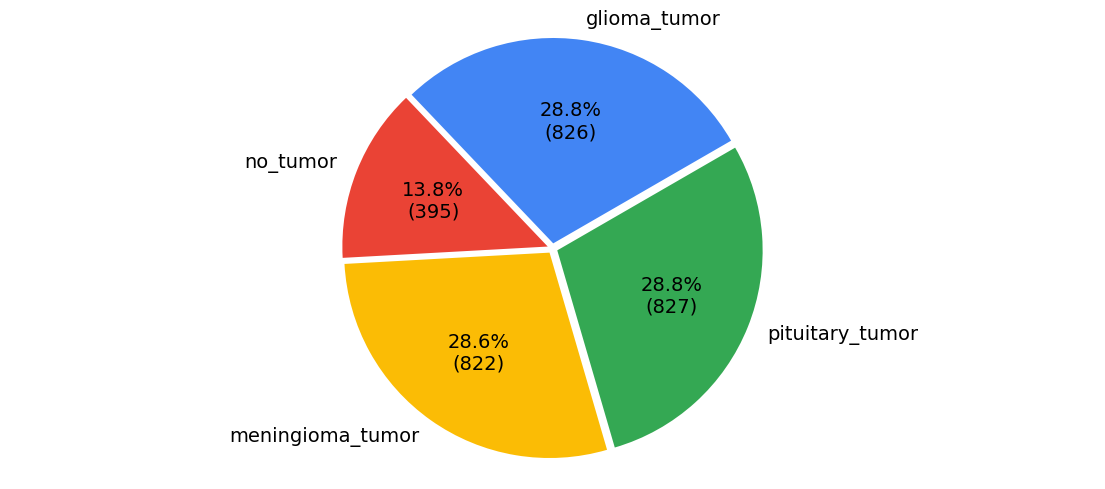

In [ ]:
import matplotlib.pyplot as plt
from collections import Counter

# Assuming the previous code to populate y_train has been executed

# Count occurrences of each label
data_balance = Counter(y_train)

plt.figure(figsize = (14, 6))
plt.rcParams.update({'font.size': 14})

def custom_autopct(pct):
    total = sum(data_balance.values())
    val = int(round(pct * total / 100.0))
    return "{:.1f}%\n({:d})".format(pct, val)

plt.pie(data_balance.values(),
        labels = data_balance.keys(),
        autopct = custom_autopct,
        colors = ['#4285f4', '#ea4335', '#fbbc05', '#34a853'],
        explode = (0.025, 0.025, 0.025, 0.025),
        startangle = 30)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()


#**Data Preprocessing and Augmentation**
This script establishes a series of image transformations, including resizing, horizontal flipping, rotation, and normalization, applied to both training and validation datasets to ensure uniform and varied input for robust model training.

Data loaders are essential for effectively managing and loading data into models, particularly when dealing with large datasets. In environments like Google Colab, the available default resources, especially RAM, can quickly be depleted. Data loaders address this issue by loading data in parallel and dividing the large dataset into smaller, more manageable batches. Additionally, they perform necessary transformations on the data before it is fed into the model, enhancing the efficiency of the data processing pipeline.

In [ ]:
from torchvision.transforms import RandomResizedCrop

data_transforms = transforms.Compose([
    # transforms.Resize((224, 224)),
    RandomResizedCrop(size= 224, scale=(0.9, 1.0), ratio=(0.999, 1.001)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


train_dataset = ImageFolder(train_dir, transform = data_transforms)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

val_dataset = ImageFolder(test_dir, transform = data_transforms)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle = True)

# Define dataloaders and dataset_sizes
dataloaders = {
    'train': train_loader,
    'val': val_loader
}

dataset_sizes = {
    'train': len(train_dataset),
    'val': len(val_dataset)
}

#**Visualize a Batch of Training Data**
The first step in a classification task is to review the training data to ensure it's loaded correctly and to identify any initial patterns. This step is crucial for confirming that the data is prepared correctly for analysis.

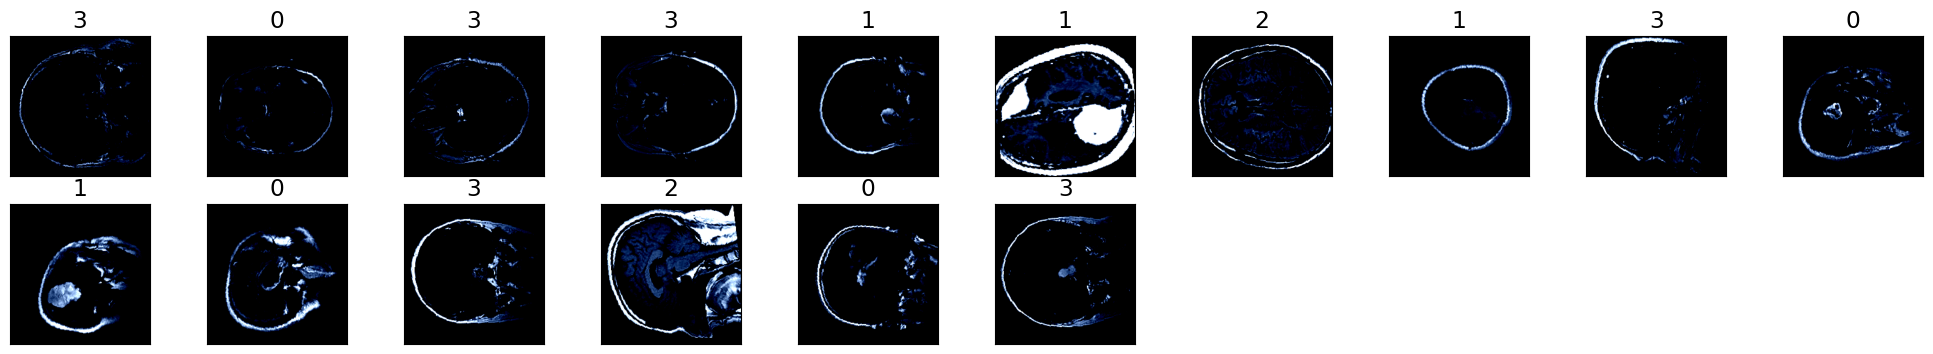

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

# obtain one batch of training images
dataiter = iter(train_loader)
images, labels  = next(dataiter)
images = images.numpy()

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(16):
    ax = fig.add_subplot(2, 10, idx + 1, xticks = [], yticks = [])
    ax.imshow(images[idx].T)
    # print out the correct label for each image
    # .item() gets the value contained in a Tensor
    ax.set_title(str(labels[idx].item()))

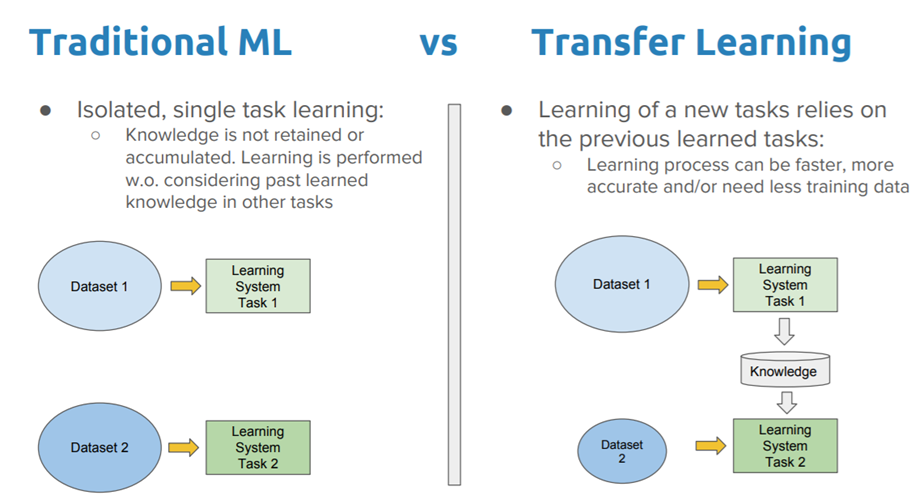

#**Load pretrained models and fine tune**
#**ResNet50**

Intitialize a pretrained ResNet50 Model from torchvision package, this model has been trained for basic features for image classification.
We will freeze the model weights, why ? beacause we already have a pretrained model (which is enough for us in this case) so we dont want the weights of the layers to change while training the model.
We will define a new fully connected layer ( this is the last layer )
Now we will set the criterians and optimizers
we will create a train function to train the model

In [ ]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Ensuring that the model and data are moved to the GPU if it is available, results in speeding up the computation.

In [ ]:
# Loading the pre-trained ResNet-50 model

model = models.resnet50( weights = 'ResNet50_Weights.DEFAULT').to(device)
print(model)
summary(model,(3, 224, 224))


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 124MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

###Lock the pre-trained layers of the model except the last 2 bottleneck blocks and the fc layer to ensure only the final layers are trainable for our specific task. This approach stops the weights of the pre-trained layers from being modified during the training process.

In [ ]:
# Freeze all layers except the last 2 bottleneck blocks and the fc layer
for name, param in model.named_parameters():
    if not name.startswith('layer4') and not name.startswith('fc'):
        param.requires_grad = False

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001, betas=(0.9, 0.999),weight_decay=1e-3)
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)


# Define Scheduler. Prevent overfitting
# If the loss value does not decrease after a specified number of epochs, the scheduler will lower the learning rate.
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=10, verbose=True)


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


In [ ]:
# %%time
# # Initialize lists to store training history
# train_losses = []
# val_losses = []
# train_accuracies = []
# val_accuracies = []

# # Training loop
# num_epochs = 20
# best_val_accuracy = 0.0

# for epoch in range(num_epochs):
#     model.train()
#     train_loss = 0.0
#     correct = 0
#     total = 0

#     for batch_idx, (inputs, labels) in enumerate(train_loader):
#         inputs, labels = inputs.to(device), labels.to(device)

#         optimizer.zero_grad()
#         outputs = model(inputs)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()

#         train_loss += loss.item()
#         _, predicted = torch.max(outputs, 1)
#         total += labels.size(0)
#         correct += (predicted == labels).sum().item()

#     train_accuracy = correct / total
#     train_losses.append(train_loss)
#     train_accuracies.append(train_accuracy)
#     scheduler.step(train_accuracy)
#     # Validation
#     model.eval()
#     val_loss = 0.0
#     correct = 0
#     total = 0

#     with torch.no_grad():
#         for inputs, labels in val_loader:
#             inputs, labels = inputs.to(device), labels.to(device)
#             outputs = model(inputs)
#             loss = criterion(outputs, labels)

#             val_loss += loss.item()
#             _, predicted = torch.max(outputs, 1)
#             total += labels.size(0)
#             correct += (predicted == labels).sum().item()

#     val_loss /= len(val_loader)
#     val_accuracy = correct / total
#     val_losses.append(val_loss)
#     val_accuracies.append(val_accuracy)

#     print(f'Epoch [{epoch+1}/{num_epochs}], '
#           f'Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.2%}, '
#           f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2%}')

%%time
import math

# Initialize lists to store training history
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Training loop
num_epochs = 20
base_lr = optimizer.defaults['lr']  # Store the initial learning rate
min_lr = base_lr / 1000             # Set the minimum learning rate at the end of training

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    correct = 0
    total = 0

    # Update learning rate with simple cosine decay
    lr = min_lr + 0.5 * (base_lr - min_lr) * (1 + math.cos(math.pi * epoch / num_epochs))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

    for batch_idx, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_accuracy = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validation
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss /= len(val_loader)
    val_accuracy = correct / total
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f'Epoch [{epoch+1}/{num_epochs}], '
          f'Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.2%}, '
          f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2%}')


Epoch [1/20], Training Loss: 95.6171, Training Accuracy: 83.45%, Validation Loss: 1.9384, Validation Accuracy: 57.11%
Epoch [2/20], Training Loss: 33.2461, Training Accuracy: 93.73%, Validation Loss: 1.0274, Validation Accuracy: 78.68%
Epoch [3/20], Training Loss: 24.2682, Training Accuracy: 95.05%, Validation Loss: 2.1402, Validation Accuracy: 67.26%
Epoch [4/20], Training Loss: 20.9888, Training Accuracy: 96.31%, Validation Loss: 1.0444, Validation Accuracy: 76.40%
Epoch [5/20], Training Loss: 14.2013, Training Accuracy: 97.14%, Validation Loss: 1.3418, Validation Accuracy: 76.90%
Epoch [6/20], Training Loss: 10.2193, Training Accuracy: 98.15%, Validation Loss: 1.4314, Validation Accuracy: 79.70%
Epoch [7/20], Training Loss: 9.1266, Training Accuracy: 98.15%, Validation Loss: 2.1169, Validation Accuracy: 76.90%
Epoch [8/20], Training Loss: 8.9025, Training Accuracy: 98.19%, Validation Loss: 1.2123, Validation Accuracy: 78.93%
Epoch [9/20], Training Loss: 5.3959, Training Accuracy: 98

#**Model Evaluation, Resnet-50**

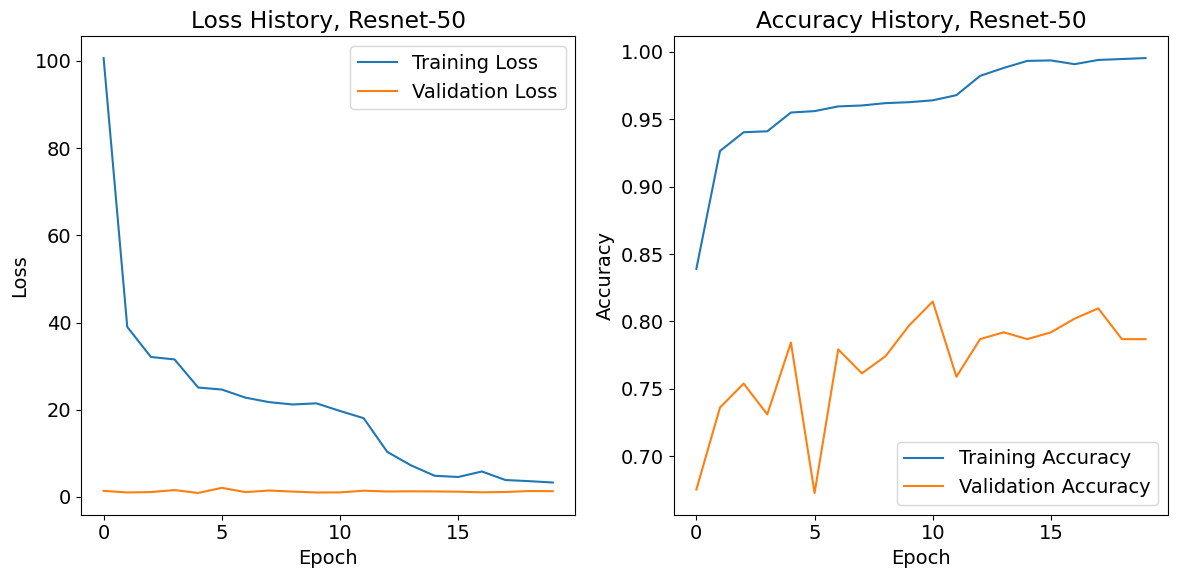

In [ ]:
# Visualize training history, Model Resnet-50
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss History, Resnet-50')

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy History, Resnet-50')

plt.tight_layout()
plt.show()

#**Confusion Matrix, Resnet-50**

Final Confusion Matrix:
tensor([[ 30,  32,  36,   2],
        [  0, 115,   0,   0],
        [  0,   0, 105,   0],
        [  0,   3,   6,  65]], device='cuda:0')


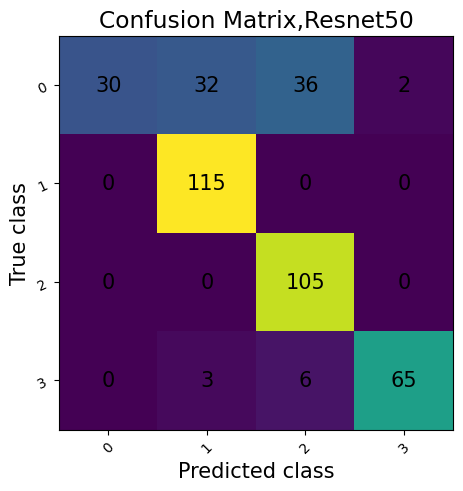

In [ ]:
# Initialize the confusion matrix metric and move it to the appropriate device(GPU)
confmat = torchmetrics.ConfusionMatrix(num_classes=4, task='multiclass').to(device)

# Ensure the model is in evaluation mode and on the same device
model.eval().to(device)

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)

        # Update confusion matrix, now everything is on the same device
        confmat.update(predicted, labels)

# Compute the final confusion matrix
final_conf_matrix = confmat.compute()

# Print the final confusion matrix
print(f'Final Confusion Matrix:\n{final_conf_matrix}')

final_conf_matrix = confmat.compute()
fig, ax = confmat.plot()
ax.set_title('Confusion Matrix,Resnet50')
plt.show()


#**VGG16**

In [ ]:
# Loading the pre-trained vgg16 model

model_vgg16 = models.vgg16(pretrained=True).to(device)
print(model_vgg16)
summary(model_vgg16,(3, 224, 224))

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
%%time
# Freeze all layers except the last 3 layers
# num_layers_to_freeze = 21  epoch 20: Validation Accuracy: 73.60%

# Freeze all layers except the last 4 layers
num_layers_to_freeze = 19 # epoch 20: Validation Accuracy: 76.65%

# Freeze layers up to num_layers_to_freeze
for i, (name, param) in enumerate(model_vgg16.named_parameters()):
    if i < num_layers_to_freeze:
        param.requires_grad = False

# Modify the classifier (fully connected layers) to fit the number of classes in your dataset
num_classes = 4  # Change this according to your dataset
model_vgg16.classifier[6] = nn.Linear(4096, num_classes)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_vgg16.classifier.parameters(), lr=0.001, momentum=0.9)

# Define Scheduler. Prevent overfitting
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_vgg16 = model_vgg16.to(device)

# Initialize lists to store training history
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Training loop
num_epochs = 20
best_val_accuracy = 0.0

for epoch in range(num_epochs):
    model_vgg16.train()
    train_loss = 0.0
    correct = 0
    total = 0

    for batch_idx, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model_vgg16(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_accuracy = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    scheduler.step()

    # Validation
    model_vgg16.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model_vgg16(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss /= len(val_loader)
    val_accuracy = correct / total
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f'Epoch [{epoch+1}/{num_epochs}], '
          f'Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.2%}, '
          f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2%}')


Epoch [1/20], Training Loss: 72.2670, Training Accuracy: 83.83%, Validation Loss: 1.4210, Validation Accuracy: 66.75%
Epoch [2/20], Training Loss: 46.4538, Training Accuracy: 90.42%, Validation Loss: 1.7402, Validation Accuracy: 67.77%
Epoch [3/20], Training Loss: 43.7196, Training Accuracy: 91.71%, Validation Loss: 1.5150, Validation Accuracy: 70.05%
Epoch [4/20], Training Loss: 37.1795, Training Accuracy: 91.95%, Validation Loss: 1.6839, Validation Accuracy: 70.81%
Epoch [5/20], Training Loss: 33.5769, Training Accuracy: 92.54%, Validation Loss: 1.5301, Validation Accuracy: 74.11%
Epoch [6/20], Training Loss: 27.2771, Training Accuracy: 94.22%, Validation Loss: 1.5390, Validation Accuracy: 74.11%
Epoch [7/20], Training Loss: 26.8560, Training Accuracy: 94.22%, Validation Loss: 1.9366, Validation Accuracy: 73.86%
Epoch [8/20], Training Loss: 21.5955, Training Accuracy: 95.78%, Validation Loss: 1.7375, Validation Accuracy: 73.35%
Epoch [9/20], Training Loss: 20.1735, Training Accuracy:

In [ ]:
list(enumerate(model_vgg16.named_parameters()))[-1]

(31,
 ('classifier.6.bias', Parameter containing:
  tensor([ 0.0033,  0.0277,  0.0031, -0.0011], device='cuda:0',
         requires_grad=True)))

#**Model Evaluation, VGG16**

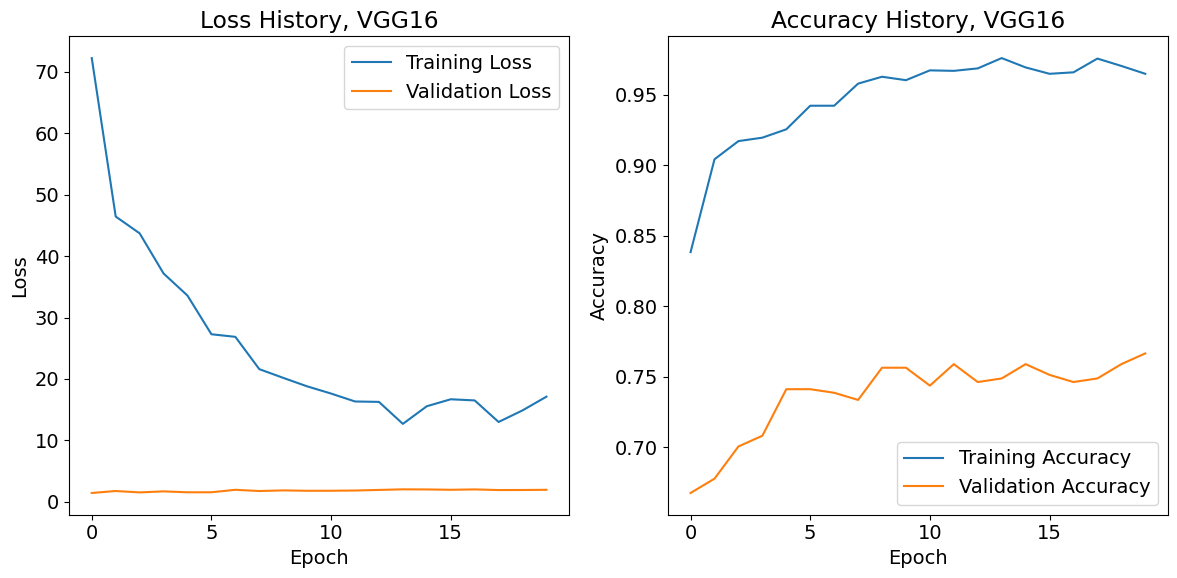

In [ ]:
# Visualize training history, Model Resnet-50
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss History, VGG16')

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy History, VGG16')

plt.tight_layout()
plt.show()

#**Confusion Matrix,VGG16**

Final Confusion Matrix:
tensor([[ 22,  52,  26,   0],
        [  0, 109,   5,   1],
        [  0,   0, 105,   0],
        [  0,   5,   6,  63]], device='cuda:0')


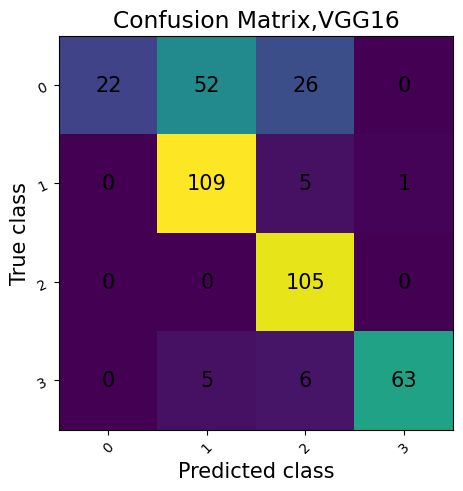

In [ ]:
# Initialize the confusion matrix metric and move it to the appropriate device(GPU)
confmat = torchmetrics.ConfusionMatrix(num_classes=4, task='multiclass').to(device)

# Ensure the model is in evaluation mode and on the same device
model_vgg16.eval().to(device)

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model_vgg16(inputs)
        _, predicted = torch.max(outputs, 1)

        # Update confusion matrix, now everything is on the same device
        confmat.update(predicted, labels)

# Compute the final confusion matrix
final_conf_matrix = confmat.compute()

# Print the final confusion matrix
print(f'Final Confusion Matrix:\n{final_conf_matrix}')

final_conf_matrix = confmat.compute()
fig, ax = confmat.plot()
ax.set_title('Confusion Matrix,VGG16')
plt.show()


#**Vision Transformer**
##**google/vit-base-patch16-224-in21kgoogle/vit-base-patch16-224-in21k**

###This model is an implementation of the Vision Transformer (ViT), a cutting-edge architecture in the field of computer vision. Specifically, it processes images that are segmented into 16x16 pixel patches and is optimized for inputs of 224x224 pixels. The model has been pre-trained on the extensive ImageNet-21k dataset, which contains over 14 million images spread across approximately 21,000 different categories.

In [ ]:
!pip install pytorch_pretrained_vit

  Preparing metadata (setup.py) ... done
  Created wheel for pytorch_pretrained_vit: filename=pytorch_pretrained_vit-0.0.7-py3-none-any.whl size=11114 sha256=8c8a968bb22c09e6359896c60b743d3b9e6afd6545e64f51818c33d515844d86
  Stored in directory: /root/.cache/pip/wheels/2d/46/ad/12007be9d377d0fbf27ef75b6e47ed92832ab6b70dbf004b6f
Successfully built pytorch_pretrained_vit


In [ ]:
from transformers import ViTFeatureExtractor, ViTForImageClassification

In [ ]:
model_name = "google/vit-base-patch16-224-in21k"
feature_extractor = ViTFeatureExtractor(model_name)
model = ViTForImageClassification.from_pretrained(model_name, num_labels=len(train_dataset.classes))

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0001)  # Adjust learning rate

# Learning rate scheduler with warm-up
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.001, total_steps=len(train_loader) * 20)

# Training loop
num_epochs = 20
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

best_validation_accuracy = 0.0

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.logits, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Validation loop
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.logits, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        validation_accuracy = 100 * correct / total

        # Save the model if validation accuracy improved
        if validation_accuracy > best_validation_accuracy:
            best_validation_accuracy = validation_accuracy
            torch.save(model.state_dict(), "best_model.pth")

    print(f"Epoch [{epoch + 1}/{num_epochs}] "
          f"Loss: {running_loss / len(train_loader):.4f} "
          f"Validation Accuracy: {validation_accuracy:.2f}%")

    # Adjust learning rate
    scheduler.step()


/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/20] Loss: 0.5760 Validation Accuracy: 70.81%
Epoch [2/20] Loss: 0.1774 Validation Accuracy: 73.86%
Epoch [3/20] Loss: 0.1137 Validation Accuracy: 73.60%
Epoch [4/20] Loss: 0.0804 Validation Accuracy: 73.35%
Epoch [5/20] Loss: 0.0492 Validation Accuracy: 76.40%
Epoch [6/20] Loss: 0.0462 Validation Accuracy: 76.65%
Epoch [7/20] Loss: 0.0403 Validation Accuracy: 78.43%
Epoch [8/20] Loss: 0.0373 Validation Accuracy: 72.84%
Epoch [9/20] Loss: 0.0287 Validation Accuracy: 74.87%
Epoch [10/20] Loss: 0.0407 Validation Accuracy: 80.46%
Epoch [11/20] Loss: 0.0259 Validation Accuracy: 76.90%
Epoch [12/20] Loss: 0.0276 Validation Accuracy: 79.19%
Epoch [13/20] Loss: 0.0200 Validation Accuracy: 77.16%
Epoch [14/20] Loss: 0.0283 Validation Accuracy: 80.96%
Epoch [15/20] Loss: 0.0168 Validation Accuracy: 72.59%
Epoch [16/20] Loss: 0.0225 Validation Accuracy: 73.60%
Epoch [17/20] Loss: 0.0170 Validation Accuracy: 77.92%
Epoch [18/20] Loss: 0.0164 Validation Accuracy: 77.92%
Epoch [19/20] Loss:

#**Conclusion**
###In this project, we explored the use of advanced transfer learning models such as VGG16, ResNet50, and Vision Transformer (ViT) for classifying multiple brain tumors, with ViT demonstrating the best overall performance.
##**Improving model performance**
Expand the Dataset: Consider enlarging the dataset to help the model learn from a broader range of images and improve its accuracy. More data can give the model a better chance to understand the nuances of different brain tumors.

Use Early Stopping: Adding early stopping to your training process is a good move. It stops the training when the model stops improving on the validation set, keeping the model efficient and focused on relevant patterns.